#1D_lineraly_Streteched_rod_with_introduced_body_force_(E=10)_with_5_layered_training_neural_network

Epoch 0, Loss: 8.566904067993164, Total_loss: 2.194300651550293
Epoch 500, Loss: 0.8167362213134766, Total_loss: 0.816736102104187
Epoch 1000, Loss: 0.8166852593421936, Total_loss: 0.8166851997375488
Epoch 1500, Loss: 0.816620409488678, Total_loss: 0.816619873046875
Epoch 2000, Loss: 0.8165328502655029, Total_loss: 0.8165326118469238
Epoch 2500, Loss: 0.816413402557373, Total_loss: 0.8164129257202148
Epoch 3000, Loss: 0.8162168264389038, Total_loss: 0.816216230392456
Epoch 3500, Loss: 0.8160120248794556, Total_loss: 0.8160041570663452
Epoch 4000, Loss: 0.8156417012214661, Total_loss: 0.8156412839889526
Epoch 4500, Loss: 0.815170168876648, Total_loss: 0.8151693344116211
Epoch 5000, Loss: 0.8146224021911621, Total_loss: 0.8145328760147095
Epoch 5500, Loss: 0.8136177062988281, Total_loss: 0.8136151432991028
Epoch 6000, Loss: 0.8118475675582886, Total_loss: 0.8118413686752319
Epoch 6500, Loss: 0.08776477724313736, Total_loss: 0.07825331389904022
Epoch 7000, Loss: 0.001103950198739767, Tota

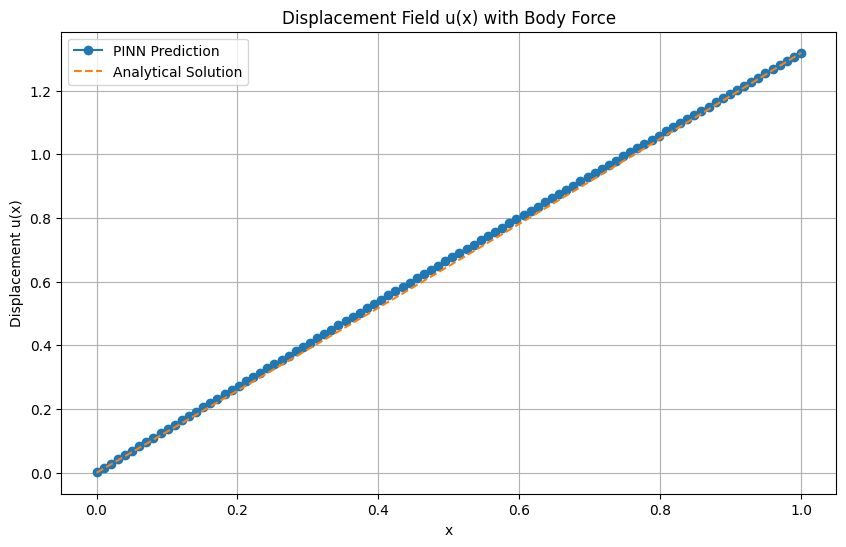

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the Neural Network for solving the PDE
class SimplePINN(tf.keras.Model):
    def __init__(self, layer_sizes):
        super(SimplePINN, self).__init__()
        self.hidden_layers = [tf.keras.layers.Dense(size, activation='tanh') for size in layer_sizes[:-1]]
        self.output_layer = tf.keras.layers.Dense(layer_sizes[-1])

    def call(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

# Function to compute PDE residual
def compute_pde_residual(model, x_vals, young_modulus, area, body_force_fn):
    with tf.GradientTape(persistent=True) as outer_tape:
        outer_tape.watch(x_vals)
        with tf.GradientTape() as inner_tape:
            inner_tape.watch(x_vals)
            predicted_u = model(x_vals)
        u_x = inner_tape.gradient(predicted_u, x_vals)
        stress = young_modulus * area * u_x
    stress_x = outer_tape.gradient(stress, x_vals)
    del inner_tape, outer_tape
    body_force = body_force_fn(x_vals)
    return stress_x + body_force

# Total loss function
def compute_total_loss(model, x_points, x_left, x_right, young_modulus, area, body_force_fn, force):
    pde_loss = tf.reduce_mean(tf.square(compute_pde_residual(model, x_points, young_modulus, area, body_force_fn)))
    # left_boundary_loss = tf.reduce_mean(tf.square(model(x_left)))
    # left_boundary_loss = tf.reduce_mean(tf.square(model(x_left)-(1 / (young_modulus * area * np.pi**2)) * (np.sin(np.pi * x_left)) + (force + (1/np.pi)) * x_left))
    left_boundary_loss = tf.reduce_mean(tf.square(model(x_left)-(((force + (1/np.pi)) * x_left)) - (1 / (young_modulus * area * np.pi**2)) * (np.sin(np.pi * x_left))))
    # right_boundary_loss = tf.reduce_mean(tf.square(model(x_right) - ( force / (young_modulus * area) + (1 / (young_modulus * area * np.pi**2)) * (1 - np.cos(np.pi)))))
    # right_boundary_loss = tf.reduce_mean(tf.square(model(x_right) - (1 / (young_modulus * area * np.pi**2)) * (np.sin(np.pi * x_right)) + (force + (1/np.pi)) * x_right))
    right_boundary_loss = tf.reduce_mean(tf.square(model(x_right) - (((force + (1/np.pi)) * x_right) - (1 / (young_modulus * area * np.pi**2)) * (np.sin(np.pi * x_right)))))
    return pde_loss + left_boundary_loss + right_boundary_loss


def body_force_fn(x):
    return tf.sin(np.pi * x)

# Problem setup
num_collocation_points = 500
x_points = tf.convert_to_tensor(np.linspace(0, 1, num_collocation_points).reshape(-1, 1), dtype=tf.float32)
x_left = tf.convert_to_tensor([[0.0]], dtype=tf.float32)
x_right = tf.convert_to_tensor([[1.0]], dtype=tf.float32)

def body_force_fn(x):
    return tf.sin(np.pi * x)

young_modulus = 10
area = 1.0
force = 1.0
layer_sizes = [1, 40, 40, 40, 1]

model = SimplePINN(layer_sizes)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
num_epochs = 10000
tolerance = 1e-5
previous_loss = float('inf')
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        loss = compute_total_loss(model, x_points, x_left, x_right, young_modulus, area, body_force_fn, force)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}, Total_loss: {compute_total_loss(model, x_points, x_left, x_right, young_modulus, area, body_force_fn, force)}")
        if abs(previous_loss - loss.numpy()) < tolerance:
            print(f"Converged at epoch {epoch}, Loss: {loss.numpy()}")
            break
        previous_loss = loss.numpy()

# Predictions and analytical solution
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
predicted_u = model(tf.convert_to_tensor(x_test, dtype=tf.float32)).numpy()
# analytical_u =  (1 / (young_modulus * area * np.pi**2)) * (np.sin(np.pi * x_test)) + (force / (young_modulus * area)) * x_test
# analytical_u =  (1 / (young_modulus * area * np.pi**2)) * (np.sin(np.pi * x_test)) + (force + (1/np.pi)) * x_test
analytical_u =  (force + (1/np.pi)) * x_test - (1 / (young_modulus * area * np.pi**2)) * (np.sin(np.pi * x_test))

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x_test, predicted_u, label="PINN Prediction", linestyle='-', marker='o')
plt.plot(x_test, analytical_u, label="Analytical Solution", linestyle='--')
plt.xlabel("x")
plt.ylabel("Displacement u(x)")
plt.title("Displacement Field u(x) with Body Force")
plt.legend()
plt.grid()
plt.show()
